In [1]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks


In [164]:
from utils_emb import *
from utils import *
import nevergrad as ng
from MKLpy import metrics
from MKLpy.utils.misc import ideal_kernel
from MKLpy.preprocessing.kernel_preprocessing import kernel_centering
from MKLpy.preprocessing.data_preprocessing import normalization
from sklearn.metrics.pairwise import pairwise_kernels
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import median_abs_deviation
from MKLpy.algorithms import AverageMKL, RMKL
from MKLpy.scheduler import ReduceOnWorsening
from MKLpy.callbacks import EarlyStopping
from sklearn.manifold import TSNE

In [3]:
def preprocess_data(df, scaler=None):
    """
    Preprocess the dataset
    1. Applys median absolute deviation (MAD)
    2. Selects the top 20% genes using MAD values
    3. Apply scaling to be in (0, 1)
    :param df: the pandas dataframes
    :param scaler: The transformer to use for scaling, by default MinMaxSclaer
    :return: a preprocessed dataframe
    """

    mad_arr = median_abs_deviation(df, axis=0)
    df_mad = pd.DataFrame(mad_arr.reshape(1, -1), columns=df.columns)
    df_mad = df_mad.sort_values(by=0, ascending=False, axis=1)
    num_cols = int(df_mad.shape[1] * 0.2)
    high_var_genes = df_mad.iloc[:, :num_cols].columns.to_list()
    df_final = df.loc[:, high_var_genes]
    if scaler is None:
        norm = MinMaxScaler()
    else:
        norm = scaler
    x = norm.fit_transform(df_final)
    df_final = pd.DataFrame(x, columns=df_final.columns, index=df_final.index)
    return df_final


In [4]:
from scipy.spatial import distance

def hadamard(v1, v2, p=1):
    v1_p, v2_p = np.power(np.absolute(v1), p), np.power(np.absolute(v2), p)
    return np.sum(np.divide(np.multiply(v1_p, v2_p), 2 * np.add(v1, v2)))

def chebyshev(x, y):
    return distance.chebyshev(x, y)

def intensional_similarity(v1, v2):
    return np.sum(np.minimum(v1, v2)) / np.sum(np.maximum(v1, v2))

In [5]:

kernel_dicts = {"tanimoto": tanimoto, "tanimoto_v2":tanimoto_v2 , "intsn": intensional_similarity, "rbf": "rbf", "cosine": "cosine", "linear": "linear", "poly": "poly"}

In [165]:
from MKLpy.algorithms import CKA, RMKL, PWMK
from sklearn.svm import SVC

from sklearn.decomposition import KernelPCA
def mkl(K_tr, K_te, y_tr, y_te, st_df, algo=CKA(), clf=SVC(kernel="precomputed", probability=True), title="kPCA Plots",
        n_comp = 300):
    algo.fit(K_tr, torch.from_numpy(y_tr.values))
    print("Weights: {0}".format(algo.solution.weights))
    K_sol = algo.solution.ker_matrix
    cv_res = cross_validate(clf, K_sol, y_tr.values, scoring=scoring, n_jobs=4, verbose=1,
                            return_train_score=True,
                            cv=st_cv)
    cv_res_df = get_scores(cv_res)
    print("Validation set scores:")
    display(cv_res_df)
    K_te = sum([mu_i * k_i for mu_i, k_i in zip(algo.solution.weights, K_te)])
    clf.fit(K_sol, y_tr.values)
    tes_res_df = calc_scores(clf, K_te, y_te.values)
    print("Test set scores:")
    display(tes_res_df)
    kpca = KernelPCA(kernel="precomputed", n_components=n_comp)
    x_transformed = kpca.fit_transform(K_sol)
    fig, ax = plt.subplots(2,2, figsize=(16, 16))
    fig.suptitle(title)
    tsne = TSNE(perplexity=50, n_iter=5000)
    x_tsne = tsne.fit_transform(x_transformed)
    x_tsne_df = pd.DataFrame(x_tsne, index=y_tr.index)
    x_tsne_df = x_tsne_df.join(st_df["RFS"])
    x_tsne_df = x_tsne_df.join(st_df["pam_coincide"])
    x_tsne_df = x_tsne_df.join(st_df["series_id"])
    sns.scatterplot(data=x_tsne_df, x=0, y=1, hue="RFS", ax=ax[0, 0])
    sns.scatterplot(data=x_tsne_df, x=0, y=1, hue="pam_coincide", ax=ax[0, 1])
    sns.scatterplot(data=x_tsne_df, x=0, y=1, hue="series_id", ax=ax[1, 0])

In [6]:
st_df = pd.read_csv("/var/www/datasets/embedding_vector_state_and_outcome.csv", index_col="patient_ID")
ge_df = pd.read_csv("/var/www/datasets/merged-combat15.csv.xz", index_col="patient_ID")


In [7]:
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE9893"]
st_tamx_df = st_df[st_df["series_id"].isin(tamoxifen_studies_v2)]
ge_out_df = ge_df.join(st_df["posOutcome"])
ge_tamx_df = ge_df.loc[st_tamx_df.index,:]
ge_out_tamx_df = ge_tamx_df.join(st_df["posOutcome"])
st_tamx_tr, st_tamx_te, y_st_tamx_tr, y_st_tamx_te = get_train_test_set(st_tamx_df, "/var/www/datasets/tamox_train_set.txt", "/var/www/datasets/tamox_test_set.txt")

In [8]:
st_tamx_df["series_id"].value_counts()

GSE17705    298
GSE9893     155
GSE12093    136
GSE1379      60
Name: series_id, dtype: int64

In [9]:
from sklearn.preprocessing import MinMaxScaler
X_ge, y_ge = ge_out_df.drop(["posOutcome"], axis=1), ge_out_df["posOutcome"]
X_ge_tr, X_ge_te, y_ge_tr, y_ge_te = train_test_split(X_ge, y_ge, shuffle=True, test_size=0.3, stratify=y_ge)
X_ge_tx_tr, X_ge_tx_te, y_ge_tx_tr, y_ge_tx_te = get_train_test_set(ge_out_tamx_df, "/var/www/datasets/tamox_train_set.txt", "/var/www/datasets/tamox_test_set.txt")

In [10]:
X_ge_tx_mad = preprocess_data(ge_tamx_df)
X_ge_tx_mad_tr, X_ge_tx_mad_te = X_ge_tx_mad.loc[X_ge_tx_tr.index], X_ge_tx_mad.loc[X_ge_tx_te.index]

In [15]:
feats_100_mrmr = load_features("/var/www/datasets/feats_100_raw_nn.txt")
ge_diff_100_df = pd.read_csv("https://raw.githubusercontent.com/singnet/cancer/master/data/curatedBreastData/diffExp/top100genes4studies.csv")
feats_diff_100 = ge_diff_100_df["symbol"].tolist()

In [16]:
X_ge_tx_mrmr_tr, X_ge_tx_mrmr_te = X_ge_tx_tr[feats_100_mrmr], X_ge_tx_te[feats_100_mrmr]
X_ge_tx_diff_tr, X_ge_tx_diff_te = X_ge_tx_tr[feats_diff_100], X_ge_tx_te[feats_diff_100]

In [17]:
qnorm = MQNormalizer()
X_ge_tx_tr_q = qnorm.fit_transform(X_ge_tx_tr)
X_ge_tx_te_q = qnorm.transform(X_ge_tx_te)
feats_100_q = load_features("/var/www/datasets/feats_100_mrmr_tamoxifen_qnormalized.txt")
X_ge_tx_tr_q_100, X_ge_tx_te_q_100 = X_ge_tx_tr_q[feats_100_q], X_ge_tx_te_q[feats_100_q]


In [84]:
def objective(gamma):
   K = pairwise_kernels(X_transformed, metric="rbf", gamma=gamma)
   K = kernel_centering(K)
   return -metrics.alignment_yy(K, torch.from_numpy(y_ge_tx_tr.values))


In [85]:
instrum = ng.p.Instrumentation(ng.p.Array(shape=(1,)).set_bounds(0, 10).set_integer_casting())
optimizer = ng.optimizers.NGOpt(parametrization=instrum, budget=100, num_workers=3)
# optimizer.register_callback("tell", objective)
# for _ in range(optimizer.budget):
#     x = optimizer.ask()
#     loss = objective(*x.args)
#     optimizer.tell(x, loss)

recommendation = optimizer.minimize(objective)
print(recommendation.value)
print(recommendation.losses)

((array([1]),), {})
[-0.10012903]


In [66]:
k_dicts_cross_15 = {"tanimoto": tanimoto ,"intsn": intensional_similarity}
_, K_cross_15_tr = compute_ker_alignment(X_ge_tr.values, X_ge_tr.values, y_ge_tr.values, k_dicts_cross_15)
_, K_cross_15_te = compute_ker_alignment(X_ge_te.values, X_ge_tr.values, y_ge_te.values, k_dicts_cross_15, train=False)
K_cross_15_tr, K_cross_15_te = [x[0] for x in K_cross_15_tr], [x[0] for x in K_cross_15_te]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.1min finished


Weights: tensor([0.4514, 0.5486], dtype=torch.float64)
Validation set scores:
Test set scores:


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.530913,0.979394,0.5436,0.082432,0.82016,0.768681,0.979394,0.521283


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.526197,0.064972,0.851852,0.987421,0.486822,0.787434,0.064972,0.514062


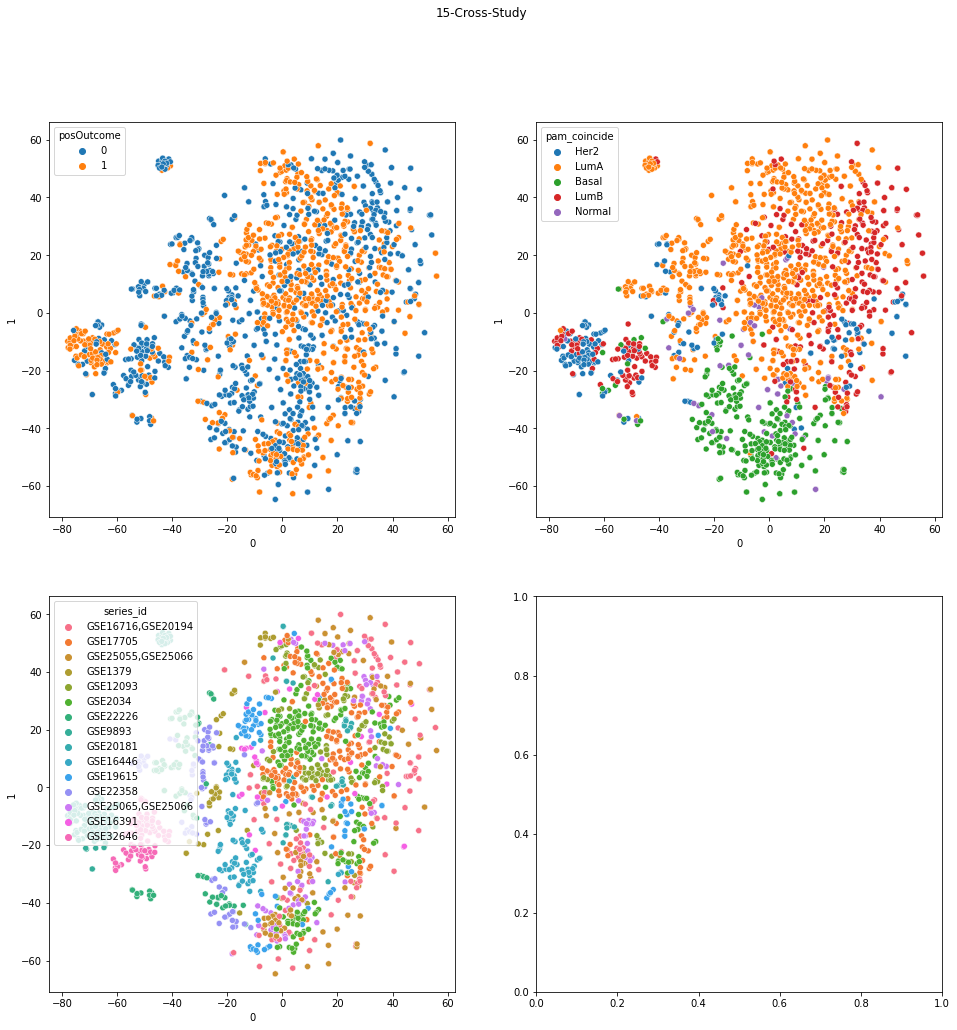

In [97]:
earlystop = EarlyStopping(
	K_cross_15_te,
	torch.from_numpy(y_ge_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)
scheduler = ReduceOnWorsening()

clf = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop],
	scheduler=scheduler)

mkl(K_cross_15_tr, K_cross_15_te, y_ge_tr, y_ge_te, st_df, algo=clf, title="15-Cross-Study")

In [68]:
k_dicts_tx = {"tanimoto": tanimoto ,"intsn": intensional_similarity}
_, K_tx_tr = compute_ker_alignment(X_ge_tx_tr.values, X_ge_tx_tr.values, y_ge_tx_tr.values, k_dicts_tx)
_, K_tx_te = compute_ker_alignment(X_ge_tx_te.values, X_ge_tx_tr.values, y_ge_tx_te.values, k_dicts_cross_15, train=False)
K_tx_tr, K_tx_te = [x[0] for x in K_tx_tr], [x[0] for x in K_tx_te]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.4s finished


Weights: tensor([0.4992, 0.5008], dtype=torch.float64)
Validation set scores:
Test set scores:


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.5,0.0,0.0,1.0,0.732734,0.753209,0.0,0.267266


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.5,0.0,0.0,1.0,0.735751,0.74496,0.0,0.264249


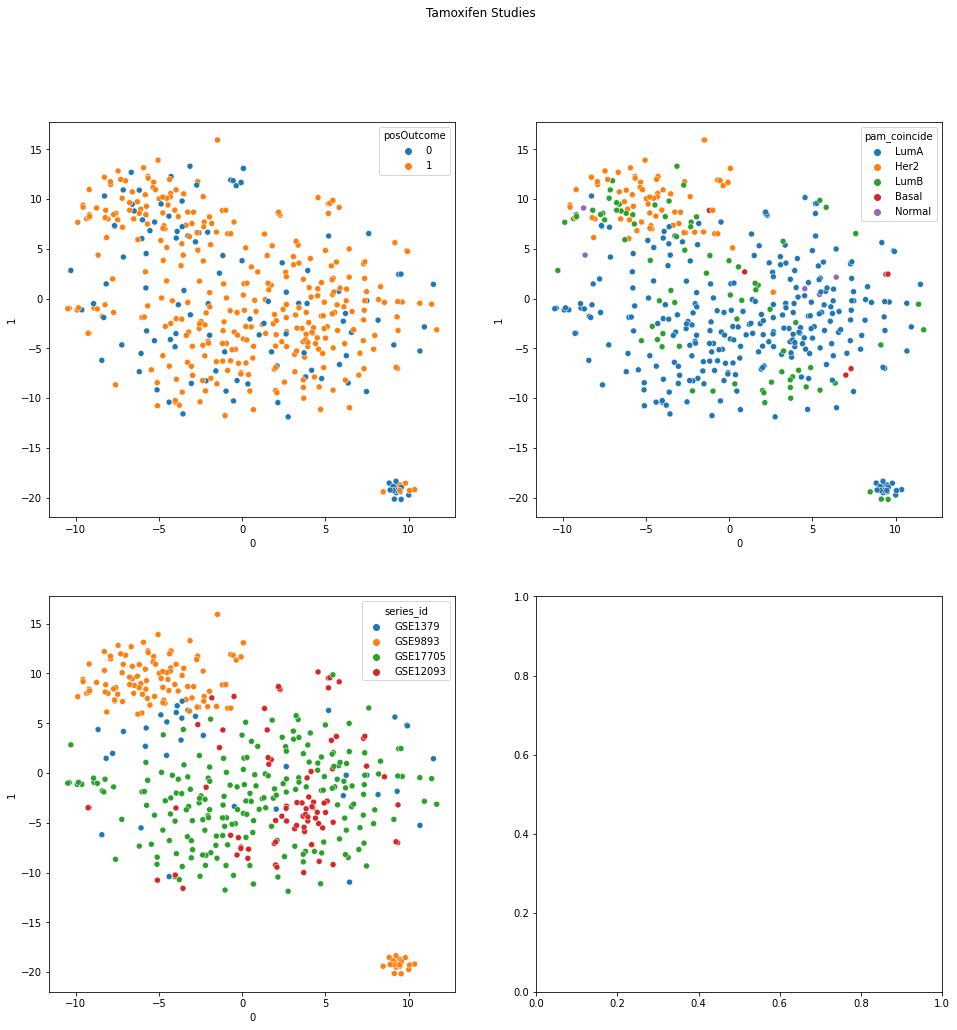

In [100]:
earlystop = EarlyStopping(
	K_tx_te,
	torch.from_numpy(y_ge_tx_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)
scheduler = ReduceOnWorsening()

clf = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop],
	scheduler=scheduler)

mkl(K_tx_tr, K_tx_te, y_ge_tx_tr, y_ge_tx_te, st_tamx_df , algo=clf, title="Tamoxifen Studies")

In [129]:
k_dicts_tx_mrmr = {"tanimoto_v2": tanimoto_v2, "linear": "linear", "intsn": intensional_similarity}
_, K_tx_mrmr_tr = compute_ker_alignment(X_ge_tx_mrmr_tr.values, X_ge_tx_mrmr_tr.values, y_ge_tx_tr.values, k_dicts_tx_mrmr)
_, K_tx_mrmr_te = compute_ker_alignment(X_ge_tx_mrmr_te.values, X_ge_tx_mrmr_tr.values, y_ge_tx_te.values, k_dicts_tx_mrmr, train=False)
K_tx_mrmr_tr, K_tx_mrmr_te = [x[0] for x in K_tx_mrmr_tr], [x[0] for x in K_tx_mrmr_te]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished


Weights: tensor([0.5000, 0.5000], dtype=torch.float64)
Validation set scores:
Test set scores:
Weights: tensor([0.0173, 0.9827], dtype=torch.float64)
Validation set scores:
Test set scores:


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.557529,0.133333,0.75,0.981725,0.756416,0.86541,0.133333,0.246805


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.529412,0.058824,1.0,1.0,0.747368,0.738884,0.058824,0.253315


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.697873,0.575,0.542093,0.820746,0.841508,0.792195,0.575,0.222553


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.5,1.0,0.264249,0.0,0.0,0.560619,1.0,0.264249


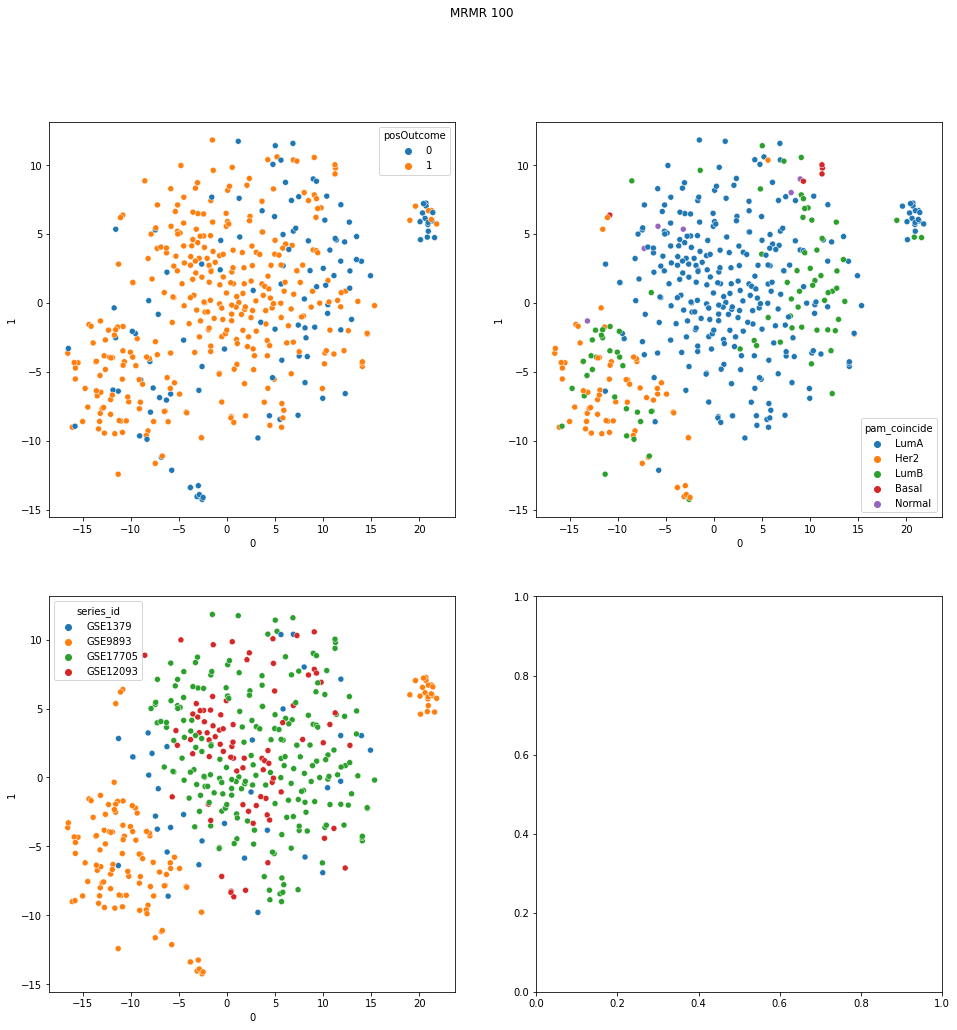

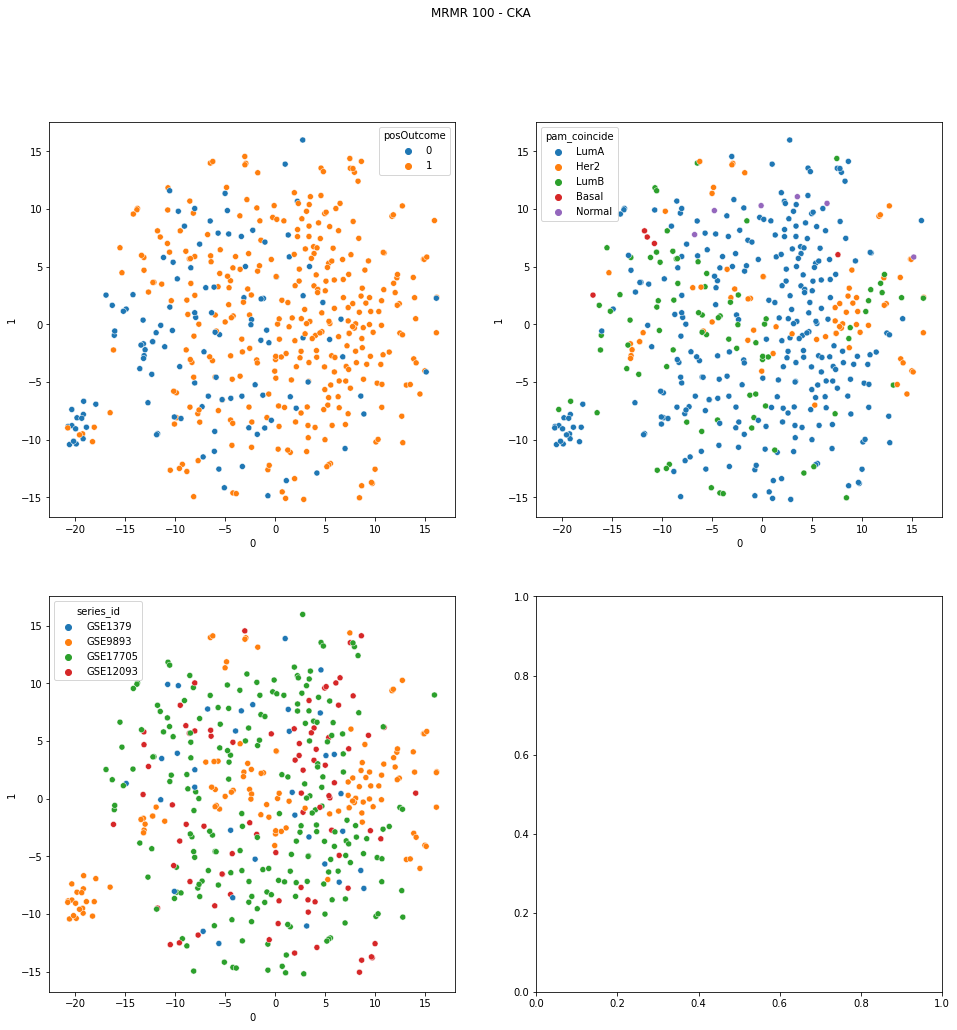

In [130]:
K_tx_mrmr_tr_v1, K_tx_mrmr_te_v1 = [K_tx_mrmr_tr[0], K_tx_mrmr_tr[2]], [K_tx_mrmr_te[0], K_tx_mrmr_te[2]]
earlystop = EarlyStopping(
	K_tx_mrmr_te_v1,
	torch.from_numpy(y_ge_tx_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)
scheduler = ReduceOnWorsening()

clf = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop],
	scheduler=scheduler)

mkl(K_tx_mrmr_tr_v1, K_tx_mrmr_te_v1, y_ge_tx_tr, y_ge_tx_te, st_tamx_df ,algo=clf, title="MRMR 100")

K_tx_mrmr_tr_v2, K_tx_mrmr_te_v2 = [K_tx_mrmr_tr[0], K_tx_mrmr_tr[1]], [K_tx_mrmr_te[0], K_tx_mrmr_te[1]]
mkl(K_tx_mrmr_tr_v2, K_tx_mrmr_te_v2, y_ge_tx_tr, y_ge_tx_te, st_tamx_df ,algo=clf, title="MRMR 100 - CKA")

In [135]:
k_dicts_tx_diff = {"tanimoto_v2": tanimoto_v2 ,"intsn": intensional_similarity, "linear": "linear"}
_, K_tx_diff_tr = compute_ker_alignment(X_ge_tx_diff_tr.values, X_ge_tx_diff_tr.values, y_ge_tx_tr.values, k_dicts_tx_diff)
_, K_tx_diff_te = compute_ker_alignment(X_ge_tx_diff_te.values, X_ge_tx_diff_tr.values, y_ge_tx_te.values, k_dicts_tx_diff, train=False)
K_tx_diff_tr, K_tx_diff_te = [x[0] for x in K_tx_diff_tr], [x[0] for x in K_tx_diff_te]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished


Weights: tensor([0.1958, 0.1958, 0.6084], dtype=torch.float64)
Validation set scores:
Test set scores:
Weights: tensor([0.5000, 0.5000], dtype=torch.float64)
Validation set scores:
Test set scores:


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.628601,0.4,0.505317,0.857203,0.796775,0.665561,0.4,0.230907


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.495236,0.941176,0.262295,0.049296,0.7,0.674261,0.941176,0.266352


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.557529,0.133333,0.75,0.981725,0.756416,0.86541,0.133333,0.246805


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.529412,0.058824,1.0,1.0,0.747368,0.738884,0.058824,0.253315


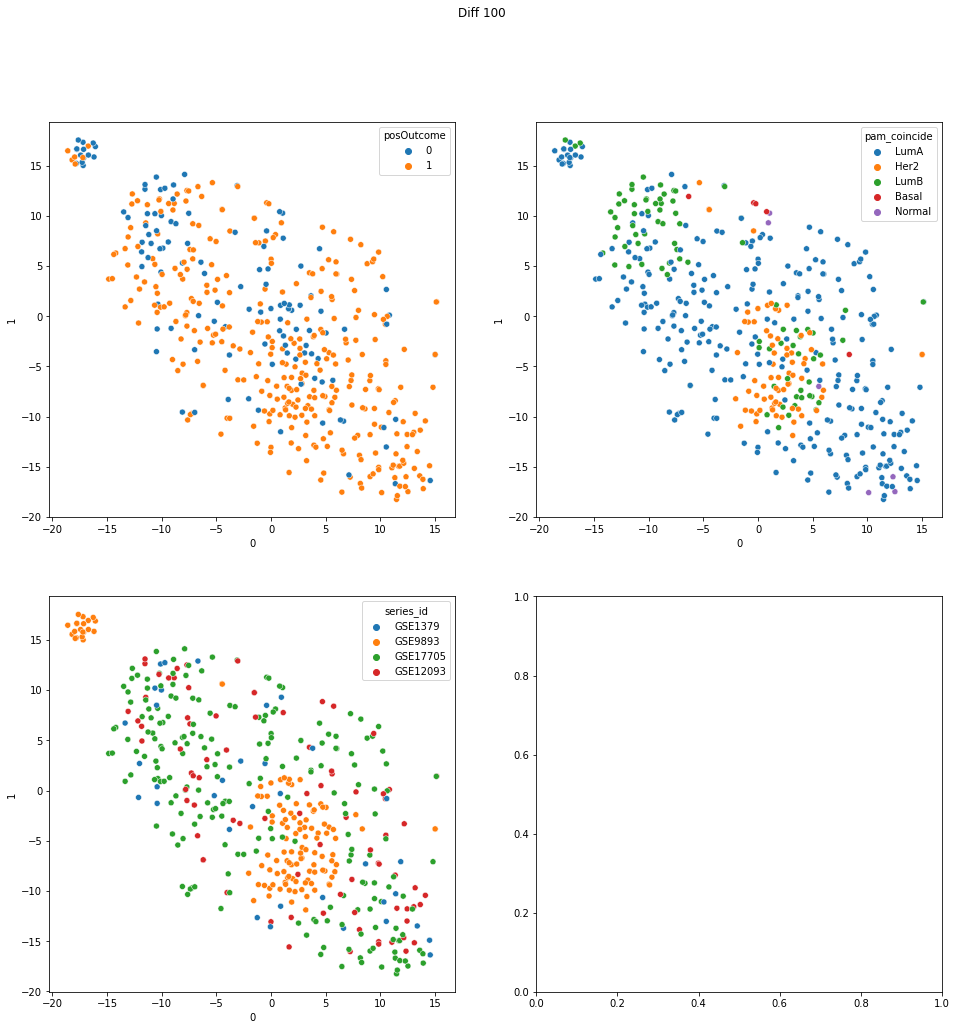

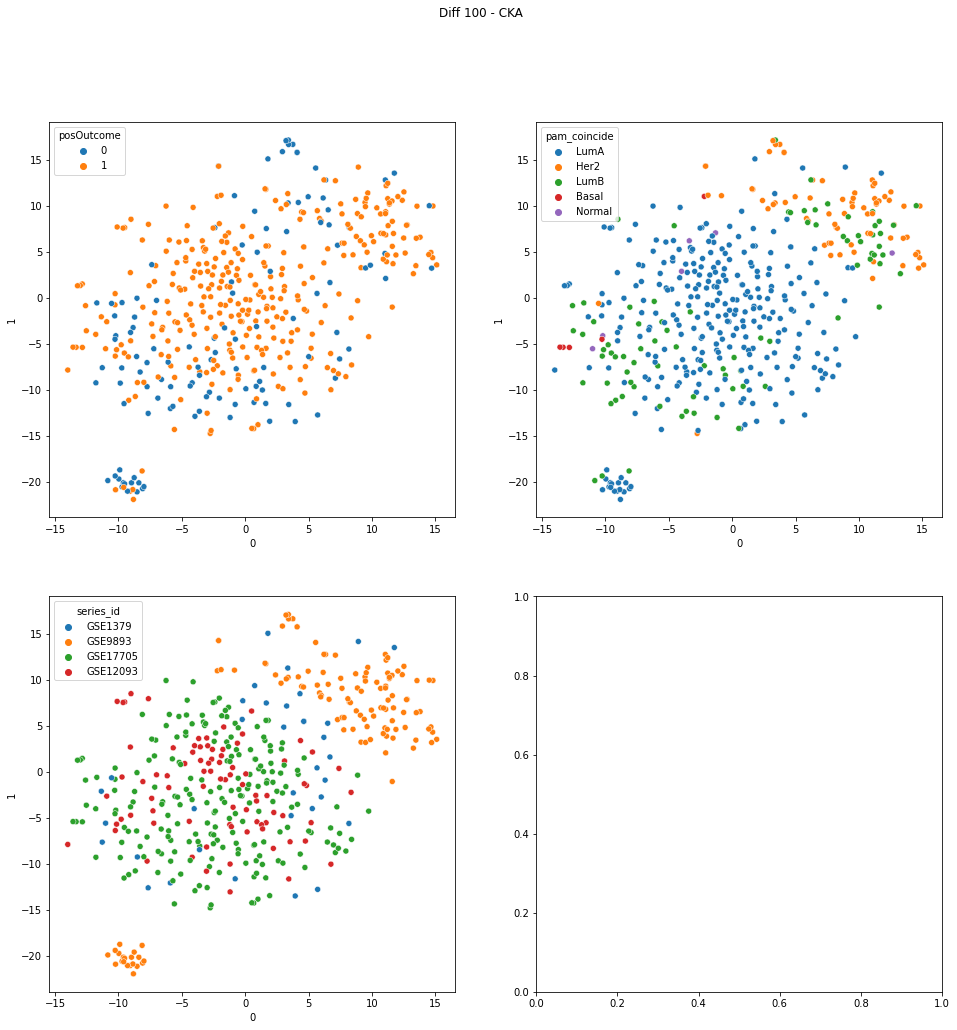

In [140]:
K_tx_mrmr_tr_v1, K_tx_mrmr_te_v1 = [K_tx_mrmr_tr[0], K_tx_mrmr_tr[2]], [K_tx_mrmr_te[0], K_tx_mrmr_te[2]]
earlystop = EarlyStopping(
	K_tx_diff_te,
	torch.from_numpy(y_ge_tx_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)

clf = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop],
	scheduler=scheduler)

mkl(K_tx_diff_tr, K_tx_diff_te, y_ge_tx_tr, y_ge_tx_te, st_tamx_df, algo=clf, title="Diff 100")

earlystop_v2 = EarlyStopping(
	K_tx_mrmr_te_v1,
	torch.from_numpy(y_ge_tx_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)

clf_v2 = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop_v2],
	scheduler=scheduler)

mkl(K_tx_mrmr_tr_v1, K_tx_mrmr_te_v1, y_ge_tx_tr, y_ge_tx_te, st_tamx_df, algo=clf_v2, title="Diff 100 - CKA")

In [131]:
k_dicts_tx_mad = {"tanimoto_v2": tanimoto_v2 ,"intsn": intensional_similarity, "linear": "linear"}
_, K_tx_mad_tr = compute_ker_alignment(X_ge_tx_mad_tr.values, X_ge_tx_mad_tr.values, y_ge_tx_tr.values, k_dicts_tx_mad)
_, K_tx_mad_te = compute_ker_alignment(X_ge_tx_mad_te.values, X_ge_tx_mad_tr.values, y_ge_tx_te.values, k_dicts_tx_mad, train=False)
K_tx_mad_tr, K_tx_mad_te = [x[0] for x in K_tx_mad_tr], [x[0] for x in K_tx_mad_te]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s finished


Weights: tensor([0.5000, 0.5000], dtype=torch.float64)
Validation set scores:
Test set scores:


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.525711,0.066667,0.533333,0.984755,0.743164,0.747424,0.066667,0.257705


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.535695,0.078431,0.8,0.992958,0.75,0.738746,0.078431,0.251118


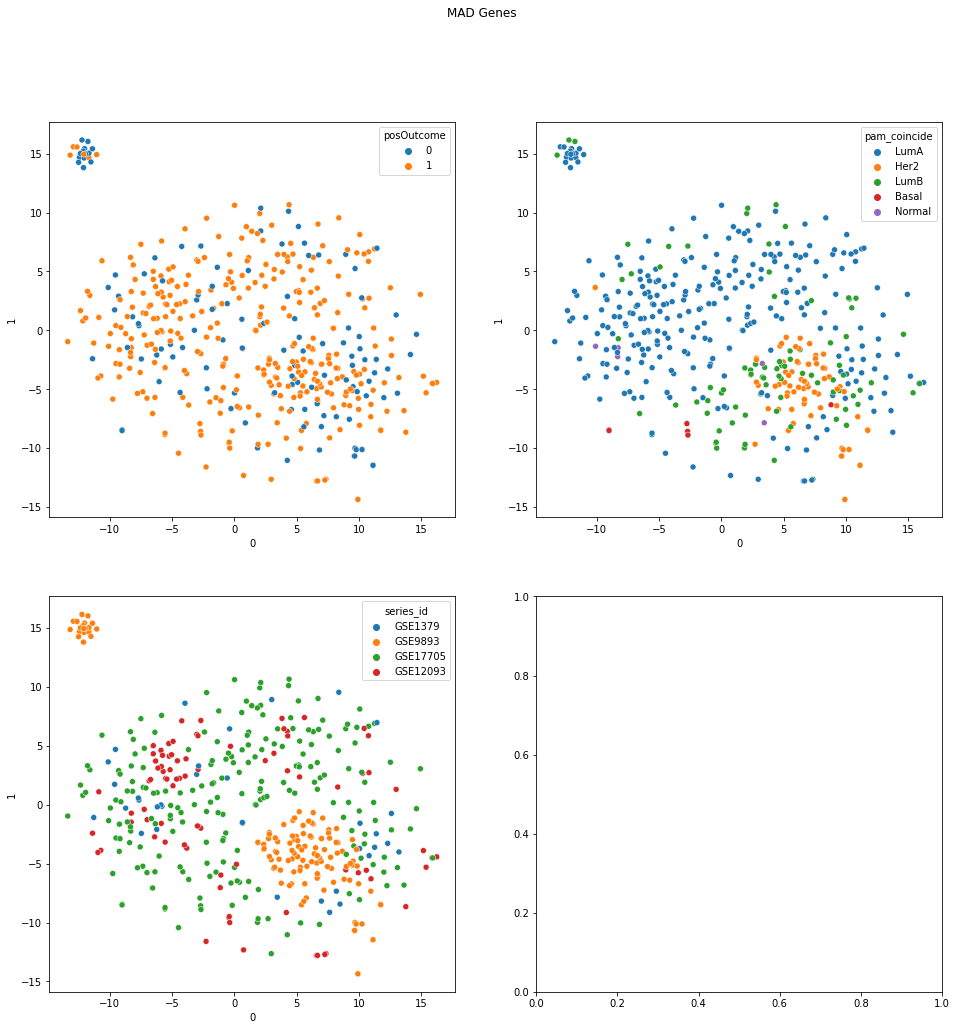

In [132]:
earlystop = EarlyStopping(
	K_tx_mad_te,
	torch.from_numpy(y_ge_tx_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)

clf = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop],
	scheduler=scheduler)

mkl(K_tx_mad_tr, K_tx_mad_te, y_ge_tx_tr, y_ge_tx_te, st_tamx_df ,algo=clf, title="MAD Genes")

In [143]:
X_ppt_mrmr_tr, X_ppt_mrmr_te = pd.read_table("/var/www/datasets/embedding-vectors/tamoxifen_group/property_vector_100genes_ge_pln_TRAIN_2021-03-25.csv", index_col="patient_ID"), pd.read_table("/var/www/datasets/embedding-vectors/tamoxifen_group/property_vector_100genes_ge_pln_TEST_2012-03-25.csv", index_col="patient_ID")
print(X_ppt_mrmr_tr.shape)
y_ppt_mrmr_tr, y_ppt_mrmr_te = X_ppt_mrmr_tr.join(st_tamx_df["posOutcome"])["posOutcome"], X_ppt_mrmr_te.join(st_tamx_df["posOutcome"])["posOutcome"]

(449, 6748)


In [144]:
k_dicts = {"tanimoto_v2": tanimoto_v2 ,"intsn": intensional_similarity, "linear": "linear"}
_, K_tx_ppt_mrmr_tr = compute_ker_alignment(X_ppt_mrmr_tr.values, X_ppt_mrmr_tr.values, y_ppt_mrmr_tr.values, k_dicts, {"rbf": {"gamma": 1}})
_, K_tx_ppt_mrmr_te = compute_ker_alignment(X_ppt_mrmr_te.values, X_ppt_mrmr_tr.values, y_ppt_mrmr_te.values, k_dicts, {"rbf": {"gamma": 1}}, train=False)
K_tx_ppt_mrmr_tr, K_tx_ppt_mrmr_te = [x[0] for x in K_tx_ppt_mrmr_tr], [x[0] for x in K_tx_ppt_mrmr_te]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s finished


Weights: tensor([0.3222, 0.3222, 0.3557], dtype=torch.float64)
Validation set scores:
Test set scores:
Weights: tensor([0.5000, 0.5000], dtype=torch.float64)
Validation set scores:
Test set scores:


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.724388,0.558333,0.662569,0.890443,0.846763,0.819233,0.558333,0.217866


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.628832,0.764706,0.351351,0.492958,0.853659,0.72763,0.764706,0.236506


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.669697,0.366667,0.832727,0.972727,0.808186,0.842409,0.366667,0.220981


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.602044,0.27451,0.583333,0.929577,0.781065,0.735294,0.27451,0.231374


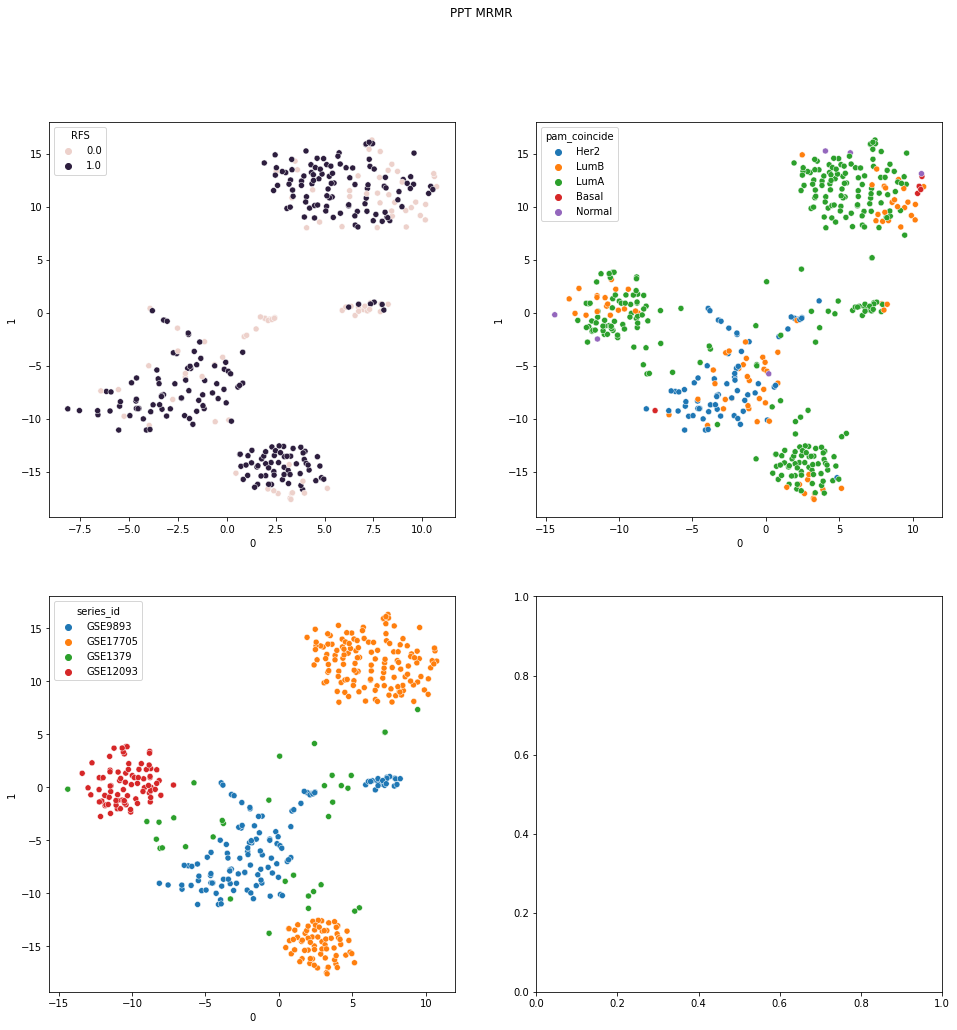

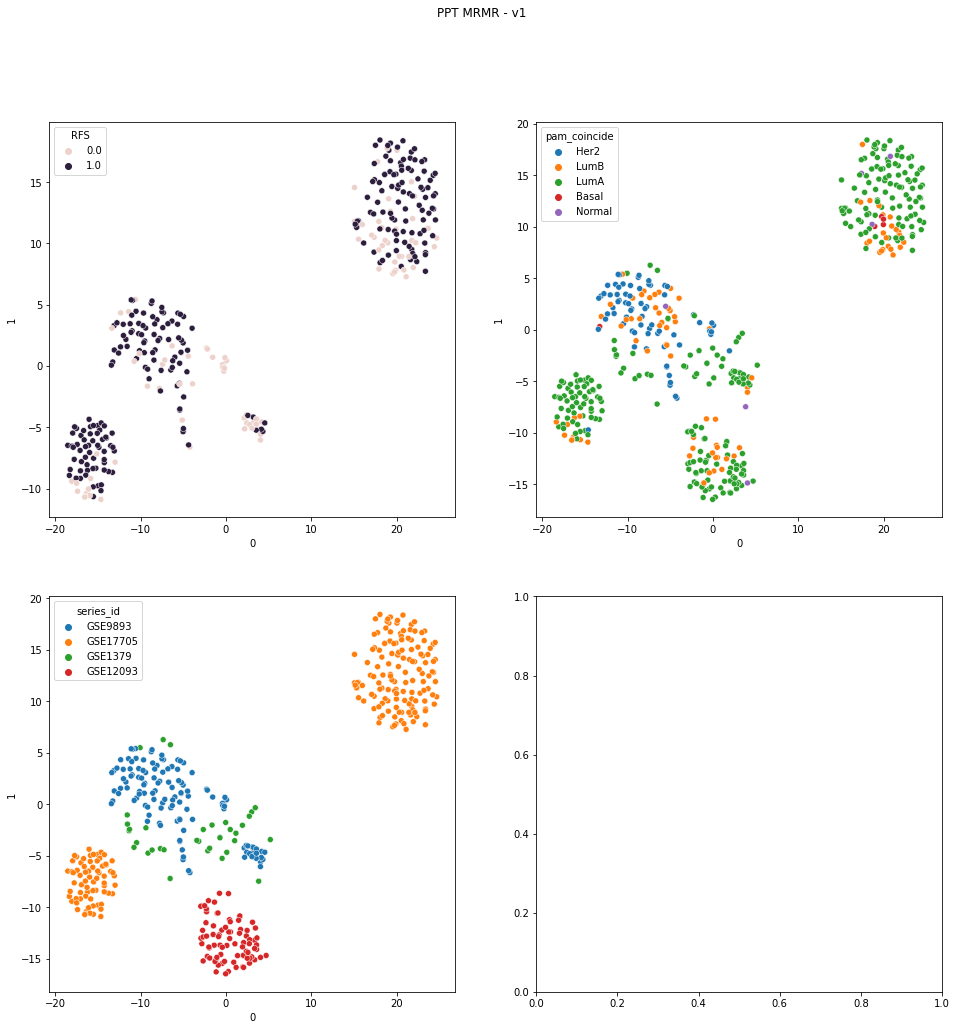

In [166]:
earlystop = EarlyStopping(
	K_tx_ppt_mrmr_te,
	torch.from_numpy(y_ppt_mrmr_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)

clf = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop],
	scheduler=scheduler)

mkl(K_tx_ppt_mrmr_tr, K_tx_ppt_mrmr_te, y_ppt_mrmr_tr, y_ppt_mrmr_te, st_tamx_df ,algo=clf, title="PPT MRMR")

K_tx_ppt_mrmr_tr_v1, K_tx_ppt_mrmr_te_v1 = [K_tx_ppt_mrmr_tr[0], K_tx_ppt_mrmr_tr[1]], [K_tx_ppt_mrmr_te[0], K_tx_ppt_mrmr_te[1]]
earlystop_2 = EarlyStopping(
	K_tx_ppt_mrmr_te_v1,
	torch.from_numpy(y_ppt_mrmr_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)

clf_2 = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop_2],
	scheduler=scheduler)
mkl(K_tx_ppt_mrmr_tr_v1, K_tx_ppt_mrmr_te_v1, y_ppt_mrmr_tr, y_ppt_mrmr_te, st_tamx_df ,algo=clf_2, title="PPT MRMR - v1", n_comp=100)

In [156]:
X_ppt_diff_tr, X_ppt_diff_te = pd.read_table("/var/www/datasets/embedding-vectors/tamoxifen_group/diffexp/property_vector_Train_2021-04-02.csv", index_col="patient_ID"), pd.read_table("/var/www/datasets/embedding-vectors/tamoxifen_group/diffexp/property_vector_Test_2021-04-02.csv", index_col="patient_ID")
print(X_ppt_diff_tr.shape)
y_ppt_diff_tr, y_ppt_diff_te = X_ppt_diff_tr.join(st_tamx_df["posOutcome"])["posOutcome"], X_ppt_diff_te.join(st_tamx_df["posOutcome"])["posOutcome"]

(449, 3740)


In [157]:
k_dicts = {"tanimoto_v2": tanimoto_v2 ,"intsn": intensional_similarity, "linear": "linear"}
_, K_tx_ppt_diff_tr = compute_ker_alignment(X_ppt_diff_tr.values, X_ppt_diff_tr.values, y_ppt_diff_tr.values, k_dicts, {"rbf": {"gamma": 1}})
_, K_tx_ppt_diff_te = compute_ker_alignment(X_ppt_diff_te.values, X_ppt_diff_tr.values, y_ppt_diff_te.values, k_dicts, {"rbf": {"gamma": 1}}, train=False)
K_tx_ppt_diff_tr, K_tx_ppt_diff_te = [x[0] for x in K_tx_ppt_diff_tr], [x[0] for x in K_tx_ppt_diff_te]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


Weights: tensor([0.3308, 0.3308, 0.3383], dtype=torch.float64)
Validation set scores:
Test set scores:
Weights: tensor([0.5000, 0.5000], dtype=torch.float64)
Validation set scores:
Test set scores:


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.610536,0.266667,0.701515,0.954406,0.780934,0.728042,0.266667,0.232105


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.5,0.0,0.0,1.0,0.735751,0.613366,0.0,0.264249


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.583689,0.191667,0.802857,0.975711,0.767965,0.734922,0.191667,0.239127


,balanced_accuracy,recall_0,precision_0,recall_1,precision_1,auc,specificity,average_precision_0
0,0.5,0.0,0.0,1.0,0.735751,0.719553,0.0,0.264249


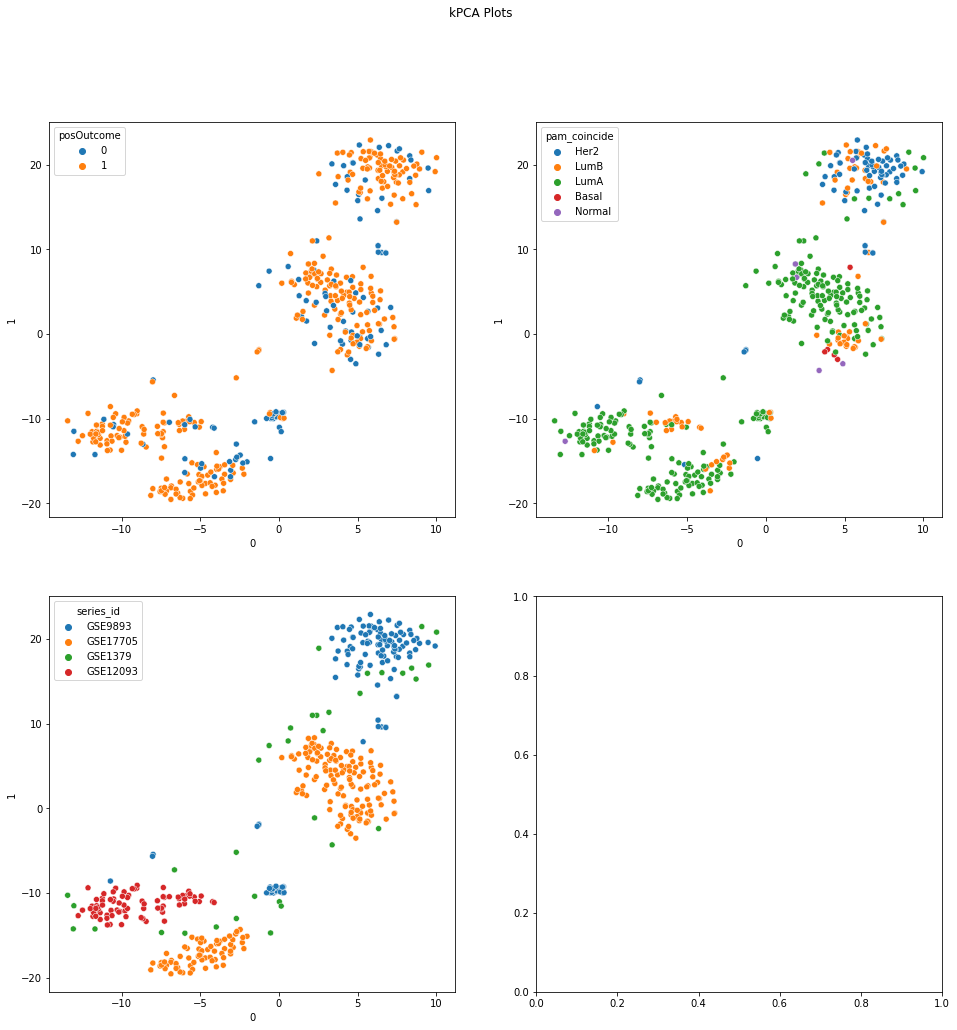

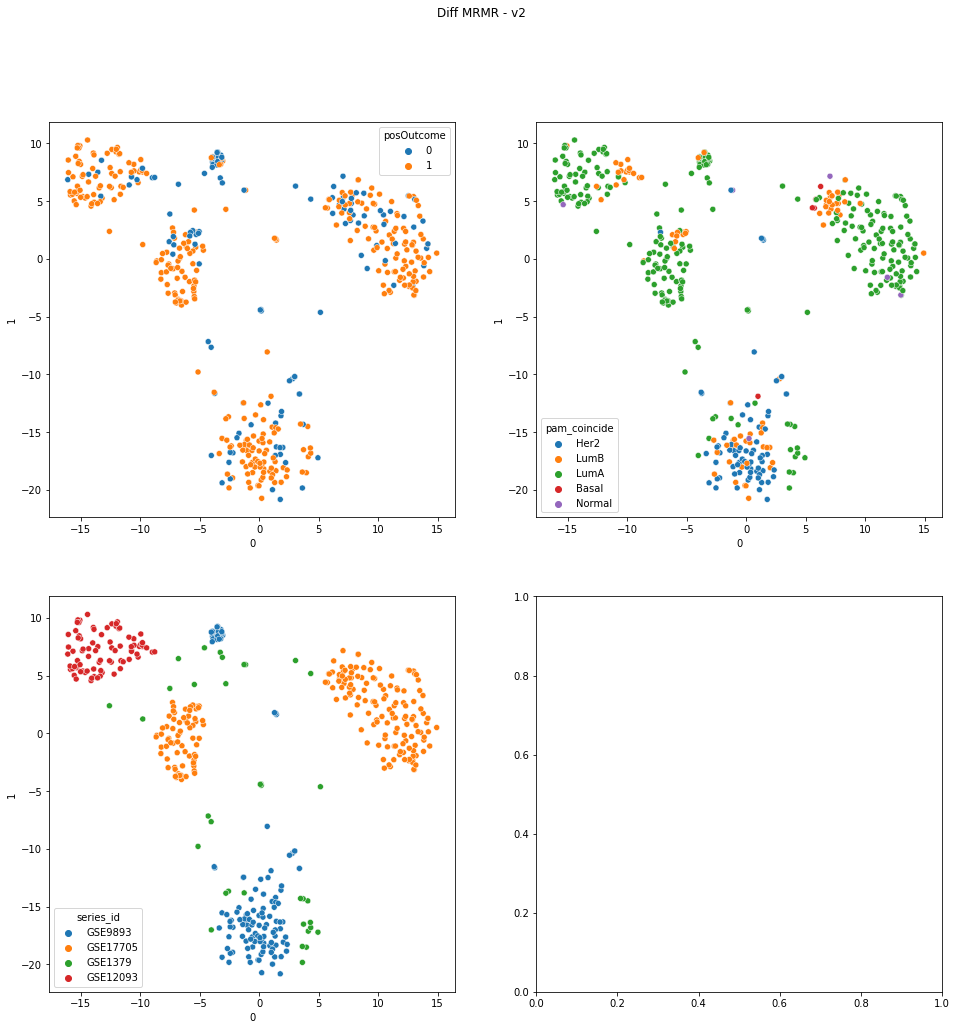

In [160]:
earlystop = EarlyStopping(
	K_tx_ppt_diff_te,
	torch.from_numpy(y_ppt_diff_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)

clf = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop],
	scheduler=scheduler)

mkl(K_tx_ppt_diff_tr, K_tx_ppt_diff_te, y_ppt_diff_tr, y_ppt_diff_te, st_tamx_df ,algo=clf)

K_tx_ppt_diff_tr_v1, K_tx_ppt_diff_te_v1 = [K_tx_ppt_diff_tr[0], K_tx_ppt_diff_tr[1]], [K_tx_ppt_diff_te[0], K_tx_ppt_diff_te[1]]
earlystop_2 = EarlyStopping(
	K_tx_ppt_diff_te_v1,
	torch.from_numpy(y_ppt_diff_te.values),
	patience=100,
	cooldown=1,
	metric='roc_auc',
)

clf_2 = RMKL(
	max_iter=1000,
	learning_rate=.1,
	callbacks=[earlystop_2],
	scheduler=scheduler)
mkl(K_tx_ppt_diff_tr_v1, K_tx_ppt_diff_te_v1, y_ppt_diff_tr, y_ppt_diff_te, st_tamx_df ,algo=clf_2, title="Diff MRMR - v2", n_comp=100)


In [88]:
from sklearn.datasets import make_classification
k_rand_dict = {"tanimoto_v2": tanimoto_v2, "intsn": intensional_similarity}
X_rand, y_rand = make_classification(n_samples=500, n_features=100, random_state=42)

scores, kers = compute_ker_alignment(X_rand, X_rand, y_rand, k_rand_dict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s finished


In [89]:
scores

({'tanimoto_v2': 0.09812194556672037}, {'intsn': 0.022405805120094397})

In [87]:
kers = [x[0] for x in kers]

kers[0] - kers[1]

tensor([[-0.6450, -0.1732, -0.0334,  ...,  0.0510,  0.0344, -0.1176],
        [-0.1732, -2.2781,  0.0058,  ..., -0.0159, -0.0310,  0.0689],
        [-0.0334,  0.0058, -1.4266,  ...,  0.0049, -0.0166,  0.0682],
        ...,
        [ 0.0510, -0.0159,  0.0049,  ..., -1.0216, -0.0050, -0.0924],
        [ 0.0344, -0.0310, -0.0166,  ..., -0.0050, -0.9717, -0.0125],
        [-0.1176,  0.0689,  0.0682,  ..., -0.0924, -0.0125, -1.7836]],
       dtype=torch.float64)

In [79]:
scores_2, kers_2 = compute_ker_alignment(X_ge_tx_mrmr_tr.values, X_ge_tx_mrmr_tr.values, y_ge_tx_tr.values, k_rand_dict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.2s finished


In [80]:
scores_2

({'tanimoto_v2': 0.1370415455174862}, {'intsn': 0.1370416672823835})

In [84]:
kers_2 = [x[0] for x in kers_2]

kers_2[0] - kers_2[1]

tensor([[ 1.2837e-06,  1.2837e-06,  1.2837e-06,  ...,  1.9618e-07,
          1.2837e-06,  1.9618e-07],
        [ 1.2837e-06,  1.2837e-06,  1.2837e-06,  ...,  1.9618e-07,
          1.2837e-06,  1.9618e-07],
        [ 1.2837e-06,  1.2837e-06,  1.2837e-06,  ...,  1.9618e-07,
          1.2837e-06,  1.9618e-07],
        ...,
        [ 1.9618e-07,  1.9618e-07,  1.9618e-07,  ..., -8.9130e-07,
          1.9618e-07, -8.9130e-07],
        [ 1.2837e-06,  1.2837e-06,  1.2837e-06,  ...,  1.9618e-07,
          1.2837e-06,  1.9618e-07],
        [ 1.9618e-07,  1.9618e-07,  1.9618e-07,  ..., -8.9130e-07,
          1.9618e-07, -8.9130e-07]], dtype=torch.float64)